In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import harmonypy as hm

from matplotlib import rcParams
from pathlib import Path
from tqdm import tqdm

import iSp3D as MODEL
from iSp3D import Func
from iSp3D import iSpaNet
from iSp3D.Classifier import iSpaNetClassifier
from iSp3D.Utils import align_spatial_slices
from iSp3D.Attribution import compute_and_summary_by_cluster
from iSp3D.Metrics import compute_ARI, compute_NMI, compute_HOM, compute_COM, compute_PAS, compute_CHAOS
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'

def inverse_pca_transform(pca, recon_pca_data):
    recon_original = pca.inverse_transform(recon_pca_data)
    return recon_original

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI

In [2]:
def get_data(proj_list, config):
    global graph_dict
    data_root = Path(r'C:\Code\Data\DLPFC\\')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_h5ad(os.path.join(r"C:\Code\Data\ME\\" + proj_name + ".MOSTA.h5ad"))
        adata_tmp.var_names_make_unique()
        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata.obsm['X_original'] = adata.X.copy()

    pca = PCA(n_components=200, random_state=42)
    adata_X = pca.fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict, pca

In [3]:
with open(r'C:\Code\iSpa3D\Config\Config_ME.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['E9.5_E1S1', 'E10.5_E2S1', 'E11.5_E1S1']
adata, graph_dict, pca = get_data(proj_list, config['data'])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:13<00:00, 24.64s/it]


In [4]:
num_cluster = config['model']['class_num']
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [5]:
method = 'mclust'

In [6]:
net.train()

Epoch 495 total loss=3.547 recon loss=0.567 tri loss=0.000 disc loss=0.574 cluster loss=3.368:  50%|█████     | 500/1000 [00:59<01:01,  8.08it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 545 total loss=3.897 recon loss=0.737 tri loss=0.184 disc loss=0.875 cluster loss=3.307:  55%|█████▌    | 550/1000 [01:58<01:05,  6.88it/s]  

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=3.851 recon loss=0.720 tri loss=0.171 disc loss=0.877 cluster loss=3.267:  60%|██████    | 600/1000 [03:03<01:11,  5.56it/s]  

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=3.805 recon loss=0.725 tri loss=0.146 disc loss=0.877 cluster loss=3.238:  65%|██████▌   | 650/1000 [04:35<01:04,  5.40it/s]  

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=3.796 recon loss=0.716 tri loss=0.155 disc loss=0.877 cluster loss=3.221:  70%|███████   | 700/1000 [05:46<00:52,  5.76it/s]  

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=3.768 recon loss=0.717 tri loss=0.135 disc loss=0.877 cluster loss=3.207:  75%|███████▌  | 750/1000 [06:52<00:43,  5.73it/s]  

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=3.772 recon loss=0.720 tri loss=0.152 disc loss=0.877 cluster loss=3.197:  80%|████████  | 800/1000 [07:54<00:31,  6.36it/s]  

fitting ...
  |======================================================================| 100%


Epoch 845 total loss=3.755 recon loss=0.716 tri loss=0.138 disc loss=0.877 cluster loss=3.190:  85%|████████▌ | 850/1000 [09:17<00:24,  6.13it/s]  

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=3.751 recon loss=0.712 tri loss=0.137 disc loss=0.877 cluster loss=3.187:  90%|█████████ | 900/1000 [10:19<00:18,  5.55it/s]

fitting ...
  |======================================================================| 100%


Epoch 945 total loss=3.735 recon loss=0.714 tri loss=0.122 disc loss=0.877 cluster loss=3.182:  95%|█████████▌| 950/1000 [11:33<00:08,  5.98it/s]

fitting ...
  |======================================================================| 100%


Epoch 995 total loss=3.741 recon loss=0.714 tri loss=0.131 disc loss=0.877 cluster loss=3.182: 100%|██████████| 1000/1000 [12:46<00:00,  1.30it/s]


In [8]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon)
adata.obsm['X_reconstructed'] = recon_original
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)
print(adata)

fitting ...
  |======================================================================| 100%
AnnData object with n_obs × n_vars = 44531 × 5000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Reg

ARI:0.3918461208695217
E9.5_E1S1 ARI:0.4522009282341738
E10.5_E2S1 ARI:0.3365502835967147
E11.5_E1S1 ARI:0.47646162156086064


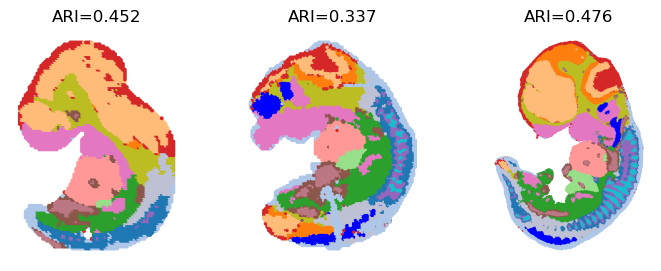

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['annotation'])]
ARI = ari_score(sub_adata.obs['annotation'], sub_adata.obs[method])
print(f"ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['proj_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['annotation'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")
    
sample_names = sub_adata.obs['batch_name'].unique()

Batch_list = []
for section_id in sample_names:
    Batch_list.append(sub_adata[sub_adata.obs['batch_name'] == section_id])

spot_size = 2
title_size = 12
ARI_list = []
for bb in range(len(sample_names)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['annotation'], Batch_list[bb].obs['mclust']), 3))

fig, ax = plt.subplots(1, len(sample_names), figsize=(3*len(sample_names), 3),
                       gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(sample_names)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=spot_size)
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)
plt.show()

In [9]:
with open('C:\\Code\\iSpa3D\\Config\\classifier_config.yaml', 'r', encoding='utf-8') as f:
    classifier_config = yaml.load(f.read(), Loader=yaml.FullLoader)
    
cluster_labels_original = adata.obs['mclust'].values.astype(int)
 
unique_labels = np.unique(cluster_labels_original)
label_mapping = {old: new for new, old in enumerate(sorted(unique_labels))}
cluster_labels_for_training = np.array([label_mapping[label] for label in cluster_labels_original])


classifier = iSpaNetClassifier(in_features=config['model']['latent_dim'], n_classes=len(unique_labels), config=classifier_config, device=device)
classifier.prepare_data(g3net_model=net, adata=adata, target_labels=cluster_labels_for_training)
classifier.train(epochs=classifier.max_epochs, verbose=True, early_stop_patience=50)

Epoch [ 10/300] Train Loss: 0.6263, Train Acc: 0.7747 | Val Loss: 0.3756, Val Acc: 0.8639
Epoch [ 20/300] Train Loss: 0.6005, Train Acc: 0.7835 | Val Loss: 0.3716, Val Acc: 0.8605
Epoch [ 30/300] Train Loss: 0.5976, Train Acc: 0.7851 | Val Loss: 0.3625, Val Acc: 0.8715
Epoch [ 40/300] Train Loss: 0.5951, Train Acc: 0.7860 | Val Loss: 0.3660, Val Acc: 0.8655
Epoch [ 50/300] Train Loss: 0.5932, Train Acc: 0.7888 | Val Loss: 0.3792, Val Acc: 0.8592
Epoch [ 60/300] Train Loss: 0.5939, Train Acc: 0.7857 | Val Loss: 0.3589, Val Acc: 0.8720
Epoch [ 70/300] Train Loss: 0.6028, Train Acc: 0.7837 | Val Loss: 0.3675, Val Acc: 0.8689
Epoch [ 80/300] Train Loss: 0.5887, Train Acc: 0.7864 | Val Loss: 0.3672, Val Acc: 0.8668
Epoch [ 90/300] Train Loss: 0.5975, Train Acc: 0.7858 | Val Loss: 0.3666, Val Acc: 0.8659
Epoch [100/300] Train Loss: 0.5980, Train Acc: 0.7839 | Val Loss: 0.3653, Val Acc: 0.8639
Epoch [110/300] Train Loss: 0.5852, Train Acc: 0.7879 | Val Loss: 0.3554, Val Acc: 0.8648
Epoch [120

In [ ]:
res_df = compute_and_summary_by_cluster(
    net=net,
    cluster_key='mclust',  
    classifier=classifier,
    batch_size=64,
    top_k=100,
    pca=pca, 
    target_clusters=None, 
    normalize= True,
    max_baselines=3,
    spatial_radius=5
)

Computing attributions for 15 clusters...


Cluster attribution:   0%|          | 0/15 [00:00<?, ?it/s]

Cluster 1: neighbors = ['7', '3', '8']


Cluster attribution:   7%|▋         | 1/15 [05:11<1:12:44, 311.73s/it]

Cluster 10: neighbors = ['15', '12', '9']


Cluster attribution:  13%|█▎        | 2/15 [10:05<1:05:17, 301.32s/it]

Cluster 11: neighbors = ['14', '7', '13', '2', '6']


Cluster attribution:  20%|██        | 3/15 [14:32<57:07, 285.66s/it]  

Cluster 12: neighbors = ['2', '15', '10', '9']


Cluster attribution:  27%|██▋       | 4/15 [19:39<53:52, 293.89s/it]

Cluster 13: neighbors = ['11', '6']


Cluster attribution:  33%|███▎      | 5/15 [23:29<45:11, 271.10s/it]

Cluster 14: neighbors = ['6', '2', '11', '4']


Cluster attribution:  40%|████      | 6/15 [27:22<38:42, 258.02s/it]

Cluster 15: neighbors = ['10', '12', '9']


Cluster attribution:  47%|████▋     | 7/15 [32:55<37:38, 282.37s/it]

Cluster 2: neighbors = ['14', '12', '5', '15', '11', '6', '9']


Cluster attribution:  53%|█████▎    | 8/15 [36:52<31:16, 268.06s/it]

Cluster 3: neighbors = ['7', '8', '6', '1']


Cluster attribution:  60%|██████    | 9/15 [43:24<30:40, 306.83s/it]

Cluster 4: neighbors = ['14']


Cluster attribution:  67%|██████▋   | 10/15 [45:07<20:19, 243.82s/it]

Cluster 5: neighbors = ['2', '7', '15', '9', '13', '6', '12']


Cluster attribution:  73%|███████▎  | 11/15 [54:06<22:17, 334.28s/it]

Cluster 6: neighbors = ['14', '3', '11', '13', '5', '7', '1', '2', '15']


Cluster attribution:  80%|████████  | 12/15 [1:00:05<17:05, 341.73s/it]

Cluster 7: neighbors = ['11', '12', '5', '3', '8', '1', '13', '6']


Cluster attribution:  87%|████████▋ | 13/15 [1:05:35<11:16, 338.18s/it]

Cluster 8: neighbors = ['3', '7', '1']


Cluster attribution:  93%|█████████▎| 14/15 [1:11:09<05:36, 336.89s/it]

Cluster 9: neighbors = ['15']


Cluster attribution: 100%|██████████| 15/15 [1:13:07<00:00, 292.50s/it]


In [ ]:
final_dfs, top_dict, per_method_dfs = res_df

for cluster_label in sorted(final_dfs.keys()):
    obj = final_dfs[cluster_label]
    
    if isinstance(obj, pd.DataFrame):
        sort_col = 'final_score' if 'final_score' in obj.columns else ('diff' if 'diff' in obj.columns else None)
        if sort_col:
            genes = obj.sort_values(sort_col, ascending=False).head(20).index.tolist()
        else:
            genes = obj.index[:20].tolist()
    else:
        genes = list(obj)[:20]
    
    print(f"Cluster {cluster_label}: {genes}")

Cluster 1: ['Nefl', 'Tubb3', 'Nefm', 'Rtn1', 'Stmn2', 'Gap43', 'Ina', 'Tagln3', 'Gng3', 'Stmn3', 'D930028M14Rik', 'Sncg', 'Ppp1r17', 'Crmp1', 'Uchl1', 'Elavl3', 'Dcx', 'Sst', 'Elavl4', 'Pou4f1']
Cluster 10: ['Rtn1', 'Ina', 'Nefl', 'Gng3', 'Gap43', 'Tubb2a', 'Mapt', 'Cryab', 'Myl1', 'Tagln3', 'Actn2', 'Fabp3', 'Tnnc1', 'Nefm', 'Tubb3', 'Stmn2', 'Ttn', 'Dcx', 'Dpysl3', 'Tnni1']
Cluster 11: ['Kctd14', 'Dppa5a', 'Sfn', 'Lhx9', 'Rpp25', 'Peg3', 'Krt7', 'Wt1', 'Ftl1', 'mt-Cytb', 'Wnt6', 'Krt19', 'Lgals7', 'Hbb-bt', 'Akr1cl', 'Wnt4', 'Krt8', 'Ifitm1', 'Pdzk1ip1', 'Bcam']
Cluster 12: ['Gpx1', 'Mylpf', 'Mybph', 'Mt1', 'Tnnc2', 'Mymk', 'Myh3', 'Ube2c', 'Epor', 'Ube2l6', 'Myl1', '2310002L09Rik', 'Grb10', 'Tcf12', 'Myog', 'Sox11', 'Casq2', 'Il17b', 'Adora1', 'Ftl1']
Cluster 13: ['Ppp1r1c', 'Ppp1r17', 'Tlx2', 'Neurod1', 'Tlx3', 'Rgs4', 'Pou4f1', 'Isl1', 'Ppp1r14a', 'Mreg', 'Kcnmb2', 'Nefm', 'Nefl', 'Ntrk1', 'Gm16104', 'Prph', 'Cotl1', 'Pou4f3', 'Hmx1', 'Isl2']
Cluster 14: ['Nudt4', 'Cldn6', 'Postn'

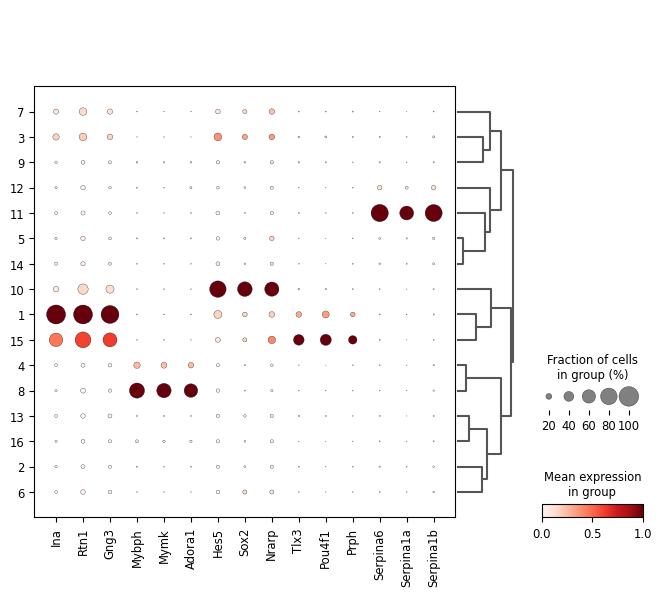

In [19]:
adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)
dg = ['Ina', 'Rtn1', 'Gng3', 'Mybph', 'Mymk', 'Adora1', 'Hes5', 'Sox2', 'Nrarp', 'Tlx3', 'Pou4f1', 'Prph', 'Serpina6', 'Serpina1a', 'Serpina1b', ]
sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=True, swap_axes=False, standard_scale='var')